In [1]:
import numpy as np
import pandas as pd
import random
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder



import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.width', 600)

In [2]:
data = pd.read_excel("datasets/online_retail_II-230817-120704.xlsx", sheet_name="Year 2010-2011")

In [3]:
df = data.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
def missing_values_analysis(df):
    na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns_].isnull().sum().sort_values(ascending=False)
    ratio_ = (df[na_columns_].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=['Total Missing Values', 'Ratio'])
    missing_df = pd.DataFrame(missing_df).sort_values(by="Ratio", ascending=False)
    return missing_df



def check_df(df, head=5):
    print("Info".center(100, '~'))
    print(df.info())
    print(" Dataframe - Head ".center(100, '~'))
    print(df.head(head))
    print("Unique Values".center(100, '~'))
    print(df.nunique())
    print(" Missing Values Analysis ".center(100, '~'))
    print(missing_values_analysis(df))
    print(' Duplicate Values Analysis '.center(100, '~'))
    print(df.duplicated().sum())

    try:
        print(" Describe Numeric ".center(100, '~'))
        print(df.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    except:
        print("There is no numeric variable in the dataset")
    
    try:
        print(" Describe Object ".center(100, '~'))
        print(df.describe(exclude=["number"]).T)

    except:
        print("There is no categorical variable in the dataset")


check_df(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Info~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Dataframe - Head ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  Invoice StockCode                          Description  Quantity         InvoiceDate  Price  Custom

In [5]:
df['TotalPrice'] = df["Price"] * df["Quantity"]

In [6]:
# Returned product analysis

df_return = df[df["Invoice"].str.contains("C", na=False)]
df_return.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96


In [7]:
# Most returned products

product_return_count = df_return.groupby(['Description', 'Customer ID'])['Invoice'].count()
product_return_count = product_return_count.reset_index()
product_return_count.columns = ['Product Name', 'Customer ID', 'Frequency of returns']
product_return_count.sort_values(by='Frequency of returns', ascending=False).head(5)

,Product Name,Customer ID,Frequency of returns
1917,Discount,14527.0,35
4111,Manual,16422.0,17
1645,CRUK Commission,14096.0,16
2464,GLASS CLOCHE SMALL,15311.0,10
5470,REGENCY CAKESTAND 3 TIER,12471.0,9


In [8]:
# Quantity of customer returns

q_returned = df_return.groupby('Customer ID')['Quantity'].sum()
q_returned = q_returned.reset_index()
q_returned.columns = ['Customer ID', 'Quantity of customer returns']
q_returned['Quantity of customer returns'] = abs(q_returned['Quantity of customer returns'])
q_returned.head()

,Customer ID,Quantity of customer returns
0,12346.0,74215
1,12352.0,66
2,12359.0,10
3,12362.0,17
4,12365.0,1


In [9]:
# Revenue lost to failed puirchases

total_return = df_return.groupby("Customer ID")["TotalPrice"].sum()
total_return = total_return.reset_index()
total_return.columns = ['Customer ID', 'Total Return']
total_return['Total Return'] = abs(total_return['Total Return'])
total_return.head()

,Customer ID,Total Return
0,12346.0,77183.60
1,12352.0,960.63
2,12359.0,127.05
3,12362.0,71.65
4,12365.0,320.69


In [10]:
# Failed purchases per month

per_month_return = df_return.set_index("InvoiceDate")["Invoice"].resample("M").count()
per_month_return = per_month_return.reset_index()
per_month_return.columns = ['Month', 'Returned/cancelled purchases']
per_month_return = per_month_return.set_index('Month')
per_month_return.T.head()

Month,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31
Returned/cancelled purchases,728,701,475,699,559,621,711,685,668,805,1200,1076,360


In [11]:
f_q_returned = pd.merge(total_return, q_returned, on='Customer ID', how='inner')
f_q_returned.head()

,Customer ID,Total Return,Quantity of customer returns
0,12346.0,77183.60,74215
1,12352.0,960.63,66
2,12359.0,127.05,10
3,12362.0,71.65,17
4,12365.0,320.69,1


In [12]:
df = df[~df["Invoice"].str.contains ("C", na=False)] # Canceled orders are removed.
df = df[(df['Quantity'] > 0)] # Quantity values less than 0 are removed.
df.dropna(inplace=True)

In [13]:
df.groupby("Description").agg({"Quantity": "sum"}).sort_values("Quantity", ascending=False)

,Quantity
Description,
"PAPER CRAFT , LITTLE BIRDIE",80995
MEDIUM CERAMIC TOP STORAGE JAR,77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS,54415
JUMBO BAG RED RETROSPOT,46181
WHITE HANGING HEART T-LIGHT HOLDER,36725
...,...
BLACK VINT ART DEC CRYSTAL BRACELET,1
FLOWER SHOP DESIGN MUG,1
SET 36 COLOURING PENCILS DOILEY,1


In [14]:
# today_date = dt.datetime.now() 
today_date = dt.datetime(2011, 12, 11)

In [15]:
df = df[df["StockCode"] != "M"]
invalid_codes = df[df["StockCode"].astype(str).str.contains(
    r"[a-zA-Z]{3,}")]["StockCode"].unique().tolist()
invalid_codes

['POST', 'BANK CHARGES', 'PADS', 'DOT']

In [16]:
print(
    df[df["StockCode"].isin(invalid_codes)].groupby(["StockCode"]).agg({"Invoice": "nunique",
                                                                        "Quantity": "sum",
                                                                        "Price": "sum",
                                                                        "Customer ID": "nunique"})
)
df = df[~df["StockCode"].isin(invalid_codes)].reset_index(drop=True)

              Invoice  Quantity      Price  Customer ID
StockCode                                              
BANK CHARGES       11        12    165.001           10
DOT                16        16  11906.360            1
PADS                4         4      0.003            4
POST             1100      3121  34713.960          331


In [17]:
# InvoiceDate = recency
# Invoice = frequency
# TotalPrice = monetary

rfm = df.groupby("Customer ID").agg(
    {"InvoiceDate": lambda recency: (today_date - recency.max()).days,
    #  "Invoice": lambda frequency: frequency.nunique(),
     "Invoice": lambda frequency: frequency.count(),
     "TotalPrice": lambda monetary: monetary.sum()
     })
rfm.columns = ["RECENCY", "FREQUENCY", "MONETARY"]
rfm.head()

,RECENCY,FREQUENCY,MONETARY
Customer ID,,,
12346.0,326,1,77183.60
12347.0,3,182,4310.00
12348.0,76,27,1437.24
12349.0,19,72,1457.55
12350.0,311,16,294.40


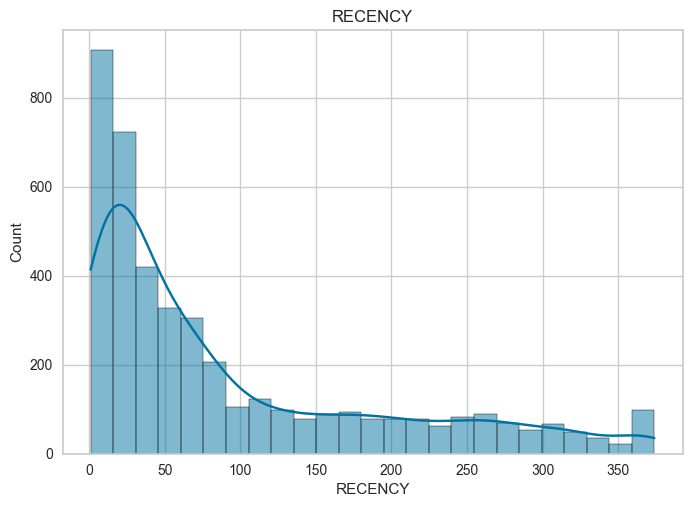

In [18]:
sns.histplot(rfm["RECENCY"], kde=True)
plt.title("RECENCY")
plt.show()

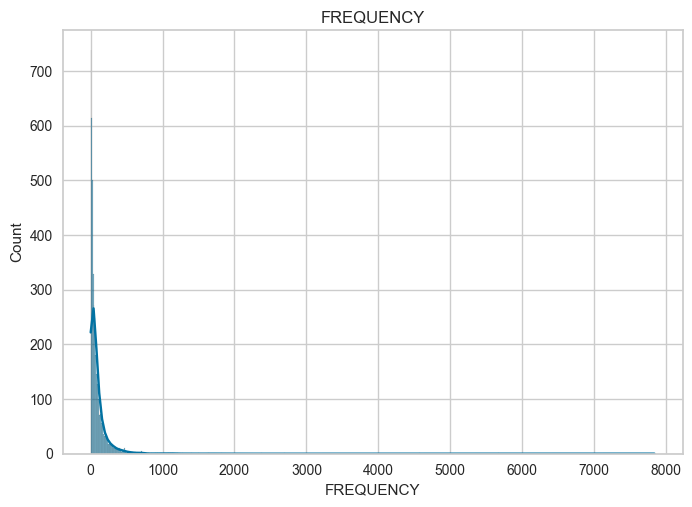

In [19]:
# rfm["FREQUENCY"].hist(bins=20)
sns.histplot(rfm["FREQUENCY"], kde=True)
plt.title("FREQUENCY")
plt.show()


In [20]:
rfm["RECENCY_SCORE"] = pd.qcut(rfm['RECENCY'], 5, labels=[5, 4, 3, 2, 1])
rfm["FREQUENCY_SCORE"] = pd.qcut(rfm['FREQUENCY'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm["MONETARY_SCORE"] = pd.qcut(rfm['MONETARY'], 5, labels=[1, 2, 3, 4, 5])
# rfm["RFM_SCORE"] = rfm['RECENCY_SCORE'].astype(str) + rfm['FREQUENCY_SCORE'].astype(str) + rfm['MONETARY_SCORE'].astype(str)
rfm["RFM_SCORE"] = rfm[['RECENCY_SCORE', 'FREQUENCY_SCORE', 'MONETARY_SCORE']].sum(axis=1)
rfm['RFM_SEGMENT'] = rfm['RECENCY_SCORE'].astype(str) + rfm['FREQUENCY_SCORE'].astype(str) + rfm['MONETARY_SCORE'].astype(str)

In [21]:
# Regular Expressions(Regex)
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Loose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

rfm['SEGMENT'] = rfm["RECENCY_SCORE"].astype(str) + rfm["FREQUENCY_SCORE"].astype(str)
rfm['SEGMENT'] = rfm['SEGMENT'].replace(seg_map, regex=True)

In [22]:
rfm.head()

,RECENCY,FREQUENCY,MONETARY,RECENCY_SCORE,FREQUENCY_SCORE,MONETARY_SCORE,RFM_SCORE,RFM_SEGMENT,SEGMENT
Customer ID,,,,,,,,,
12346.0,326,1,77183.60,1,1,5,7,115,Hibernating
12347.0,3,182,4310.00,5,5,5,15,555,Champions
12348.0,76,27,1437.24,2,2,4,8,224,Hibernating
12349.0,19,72,1457.55,4,4,4,12,444,Loyal Customers
12350.0,311,16,294.40,1,2,2,5,122,Hibernating


# Outliers

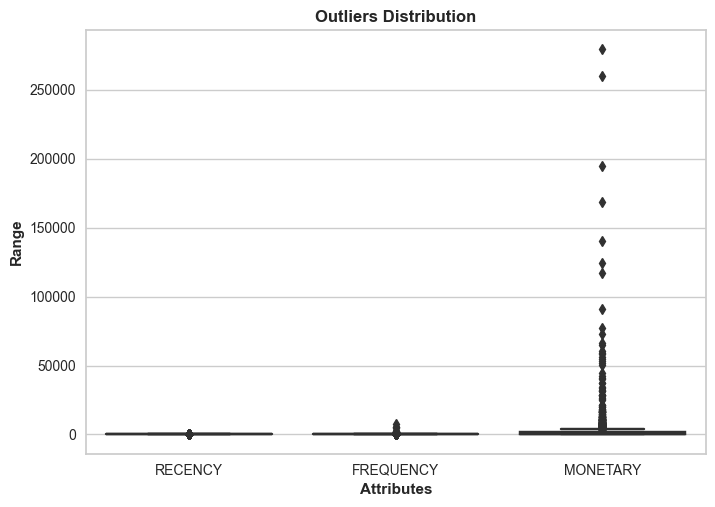

In [23]:
attributes = ['RECENCY', 'FREQUENCY', 'MONETARY']
sns.boxplot(data = rfm[attributes])
plt.title("Outliers Distribution", fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')
plt.show()

In [24]:
def check_outlier(dataframe, col_name, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    outliers = dataframe[(dataframe[col_name] > up_limit)
                         | (dataframe[col_name] < low_limit)]
    return outliers


def outlier_thresholds(dataframe, col, low_quantile=0.07, up_quantile=0.93):

    quantile_one = dataframe[col].quantile(low_quantile)
    quantile_three = dataframe[col].quantile(up_quantile)

    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range

    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [25]:
for col in attributes:
    outliers = check_outlier(rfm, col)
    if not outliers.empty:
        print(col, outliers.shape[0], "outliers")
        replace_with_thresholds(rfm, col)

FREQUENCY 29 outliers
MONETARY 62 outliers


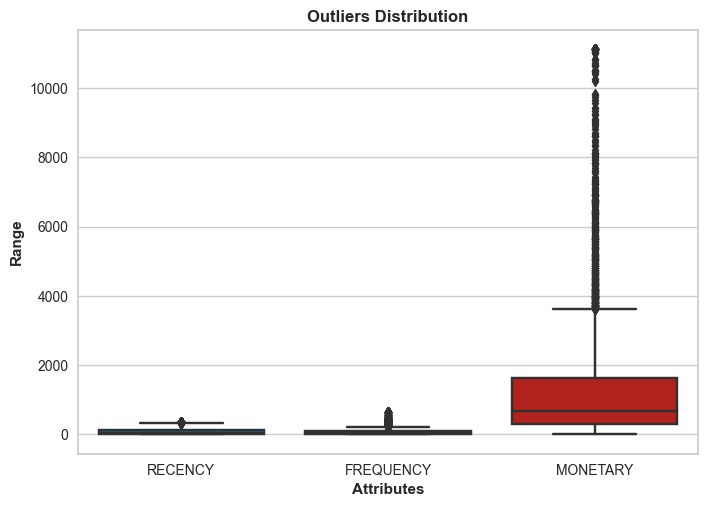

In [26]:
attributes = ['RECENCY', 'FREQUENCY', 'MONETARY']
sns.boxplot(data = rfm[attributes])
plt.title("Outliers Distribution", fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')
plt.show()

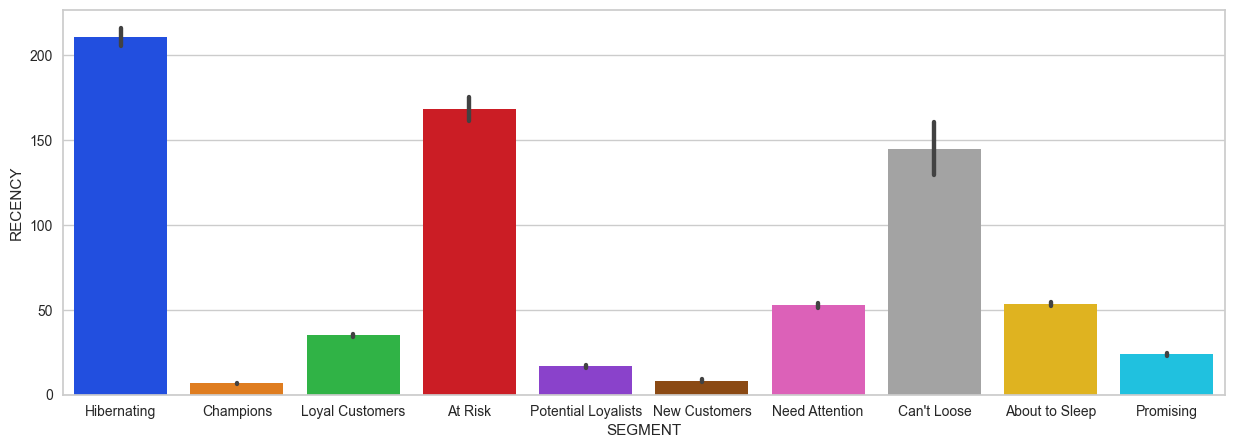

In [31]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(x="SEGMENT", y="RECENCY", palette="bright", data=rfm)

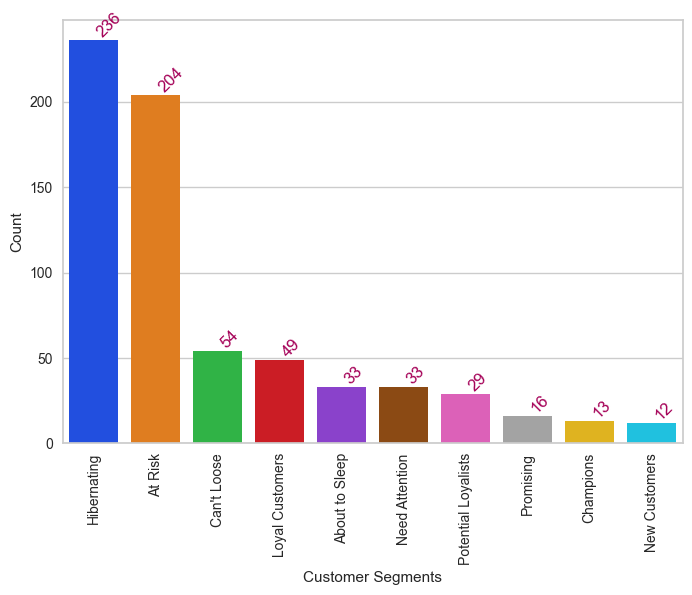

In [39]:
rec_seg = rfm.groupby("SEGMENT").agg({"RECENCY": "nunique"}).sort_values("RECENCY", ascending=False).reset_index()
ax = sns.barplot(x="SEGMENT", y="RECENCY", palette="bright", data=rec_seg)

# Use FuncFormatter from the ticker module
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "{:,}".format(int(x))))
ax.set(xlabel="Customer Segments", ylabel='Count')

# Add proper Dim values as x labels and rotate them
ax.set_xticklabels(rec_seg["SEGMENT"])
for item in ax.get_xticklabels():
    item.set_rotation(90)

# Add value labels on top of the bars
for i, v in enumerate(rec_seg.iterrows()):
    ax.text(i, v[1]["RECENCY"], "{:,}".format(v[1]["RECENCY"]), color='m', va='bottom', rotation=45)



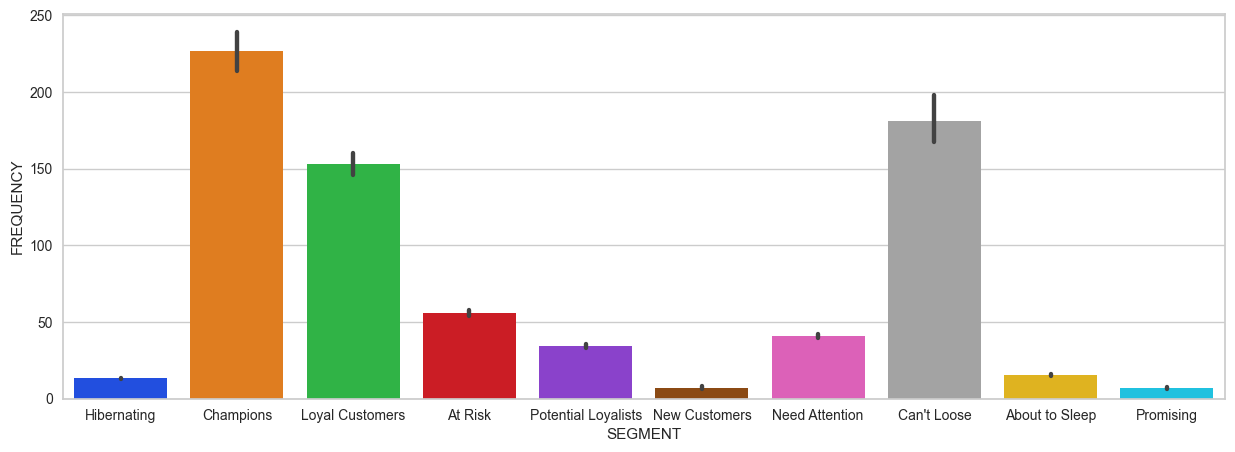

In [33]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(x="SEGMENT", y="FREQUENCY", palette="bright", data=rfm)

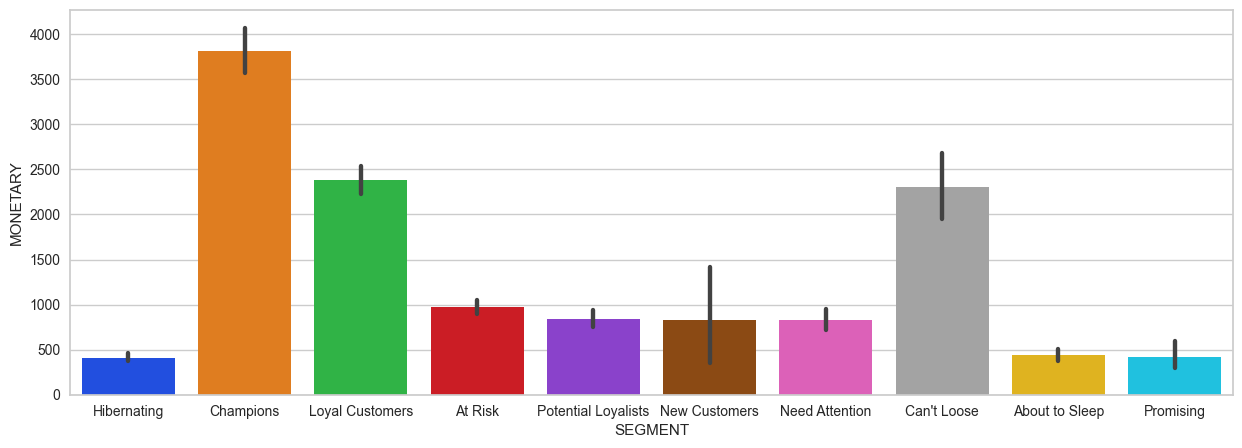

In [34]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(x="SEGMENT", y="MONETARY", palette="bright", data=rfm)

In [40]:
rfm[["SEGMENT", "RECENCY", "FREQUENCY", "MONETARY"]].groupby("SEGMENT").agg(["mean","median","count", "std"])


RECENCY                           FREQUENCY                              MONETARY                             
                           mean median count        std        mean median count         std         mean    median count          std
SEGMENT                                                                                                                               
About to Sleep        53.450479   53.0   313  11.040061   15.597444   15.0   313    7.873861   438.232428   316.700   313   614.327460
At Risk              168.257732  146.0   582  83.516922   56.048110   50.0   582   22.741708   972.410687   711.035   582   995.707660
Can't Loose          144.702381  119.5    84  73.894549  181.333333  156.0    84   71.027796  2305.900714  2060.175    84  1684.960751
Champions              6.710863    6.0   626   4.014108  226.707668  166.0   626  165.921203  3816.565598  2607.200   626  3249.039044
Hibernating          210.589792  212.0  1058  89.641227   13.331758   13.0  1058    7.951161   409.007832   277.435  1058   778.188137
Loyal Customers       34.904881   31.0   799  15.497707  153.307134  115.0   799  107.749589  2384.366471  1720.300   799  2163.850848
Need Attention        52.719048   53.0   210  11.477964   40.857143   39.5   210    8.294148   828.414898   668.905   210   955.250677
New Customers          8.177419    8.0    62   4.026650    7.177419    7.5    62    3.881542   827.092213   215.130    62  2145.276206
Potential Loyalists   16.780876   17.0   502   9.253137   34.348606   33.0   502   12.742968   842.535151   595.335   502  1085.861125
Promising             23.757576   23.0    99   5.166791    7.252525    7.0    99    3.645919   419.389293   192.600    99   798.866476

# Clustering with the K-Means Algorithm

In [46]:
# LOG TRANSFORMATION
for col in ["RECENCY", "FREQUENCY", "MONETARY"]:
    rfm[f"LOG_{col}"] = np.log1p(rfm[col])

# SCALER
sc = MinMaxScaler((0, 1))
sc.fit(rfm[["RECENCY", "FREQUENCY", "MONETARY"]])
scaled_rf = sc.transform(rfm[["RECENCY", "FREQUENCY", "MONETARY"]])

scaled_df = pd.DataFrame(index=rfm.index, columns=[
                         "RECENCY", "FREQUENCY", "MONETARY"], data=scaled_rf)
scaled_df

,RECENCY,FREQUENCY,MONETARY
Customer ID,,,
12346.0,0.871314,0.000000,1.000000
12347.0,0.005362,0.283233,0.387627
12348.0,0.201072,0.040685,0.129261
12349.0,0.048257,0.111102,0.131087
12350.0,0.831099,0.023472,0.026477
...,...,...,...
18280.0,0.742627,0.014083,0.016243
18281.0,0.482574,0.009389,0.007269
18282.0,0.018767,0.017213,0.016013


<Axes: >

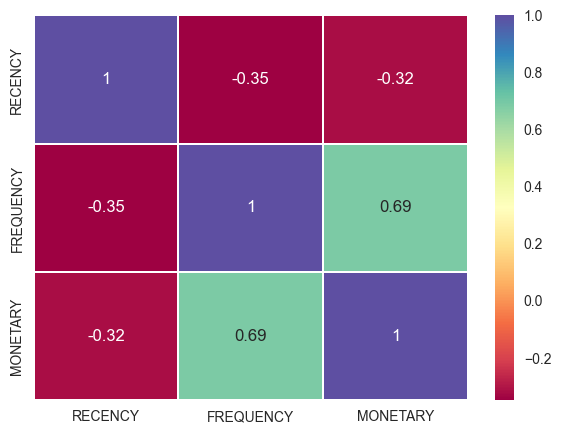

In [47]:
plt.figure(figsize=(7,5))
sns.heatmap(scaled_df.corr(), cmap='Spectral', linewidths = .2, annot=True)

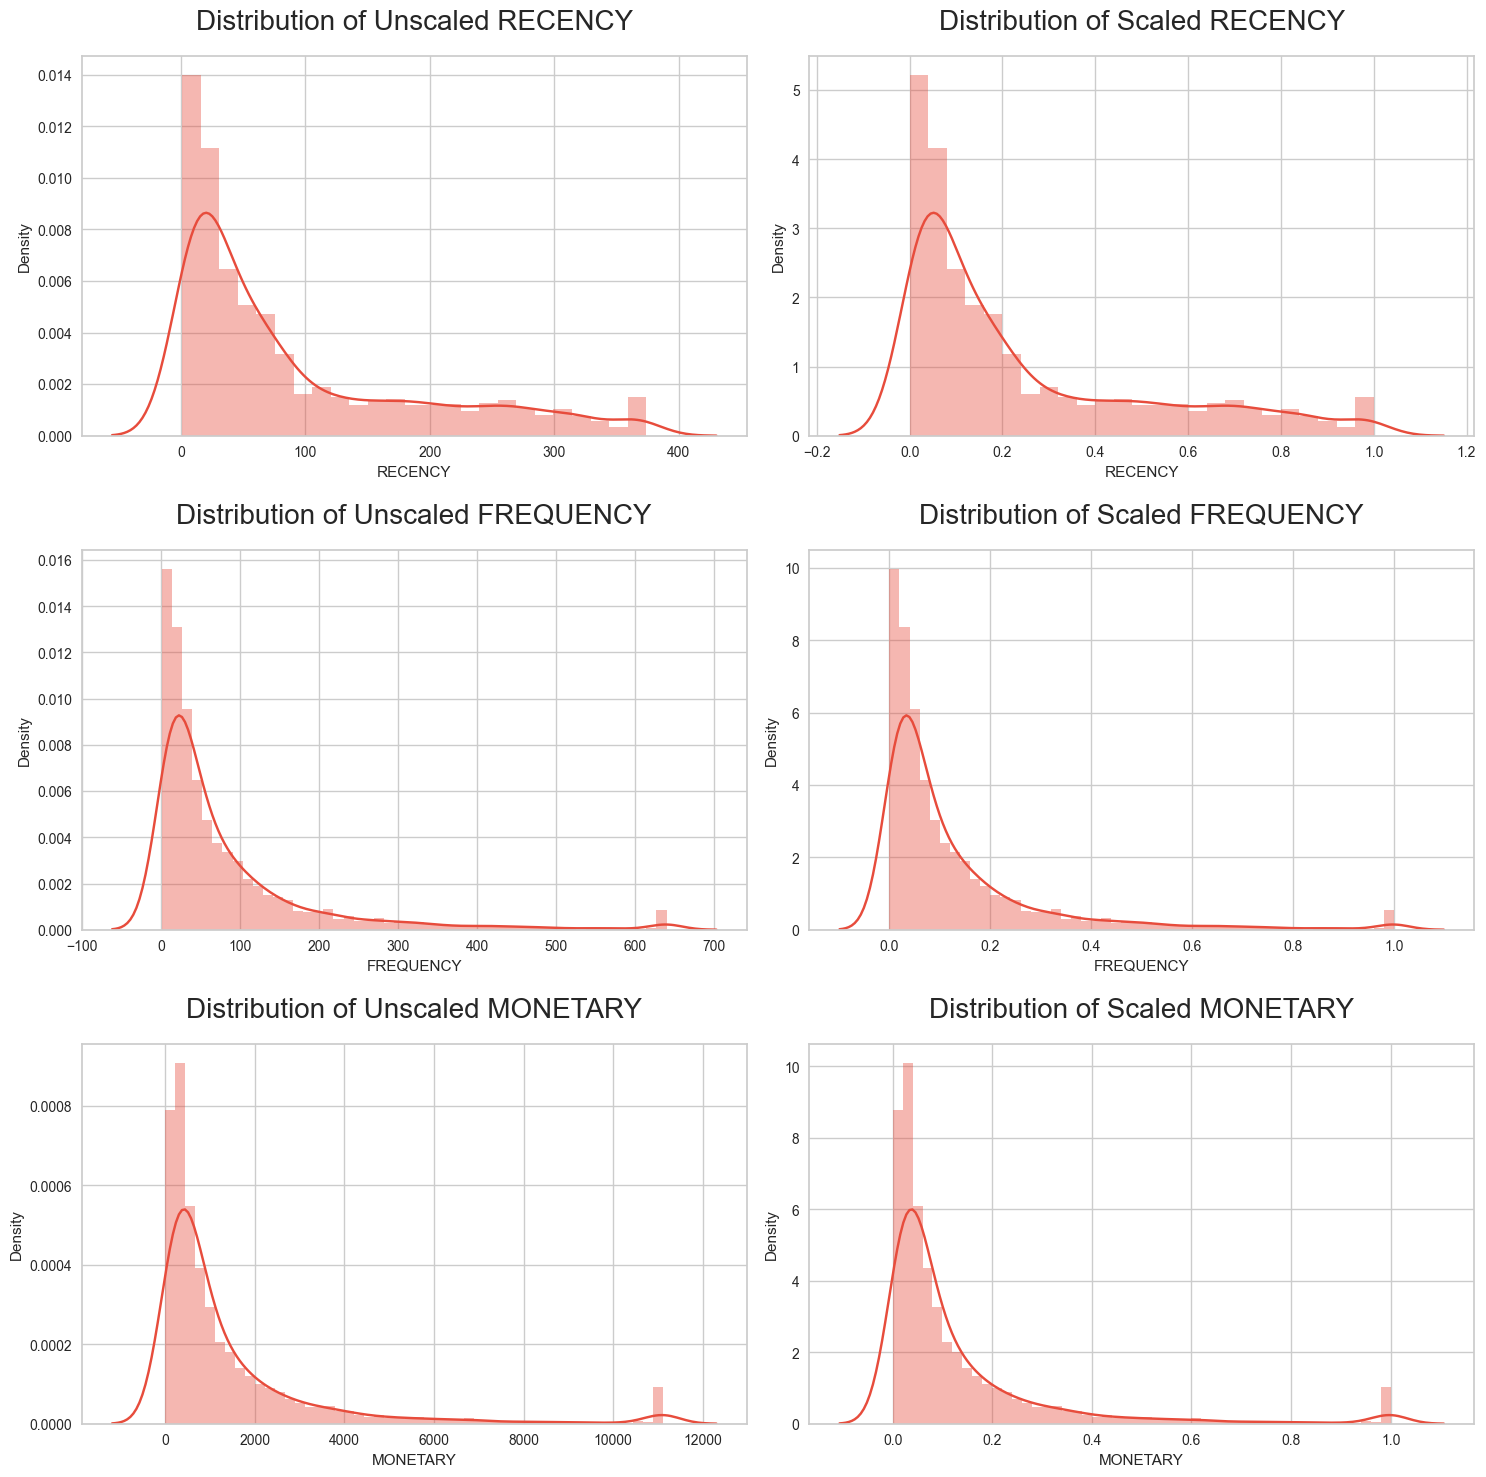

In [50]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(15,15))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(scaled_df.columns.tolist()):
    sns.distplot(rfm[feature],  hist=True, color='#e74c3c', ax=ax[i][0])    
    sns.distplot(scaled_df[feature], hist=True, color='#e74c3c', ax=ax[i][1])
    
    ax[i][0].set_title(f'Distribution of Unscaled {feature}', size=20, y=1.05)
    ax[i][1].set_title(f'Distribution of Scaled {feature}', size=20, y=1.05)
    
plt.tight_layout() 

# Determining the Optimum Number of Clusters

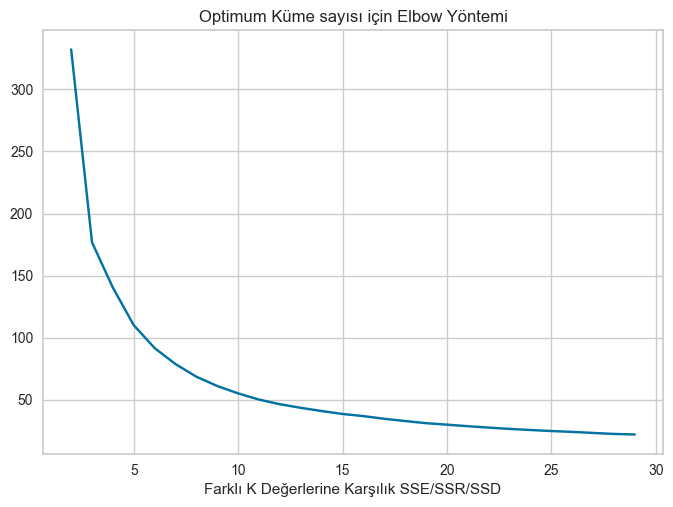

In [53]:
kmeans = KMeans()
ssd = []
K = range(2, 30)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(scaled_df)
    ssd.append(kmeans.inertia_)

plt.plot(K, ssd, "bx-")
plt.xlabel("Farklı K Değerlerine Karşılık SSE/SSR/SSD")
plt.title("Optimum Küme sayısı için Elbow Yöntemi")
plt.show()

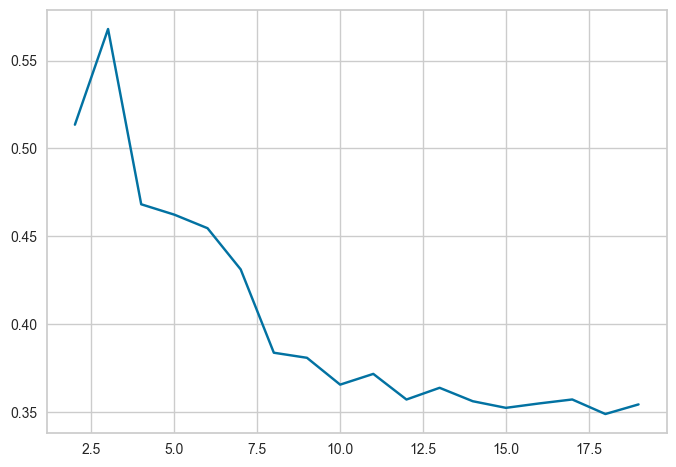

In [54]:
from sklearn.metrics import silhouette_score as SS
sse_ = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k).fit(scaled_df)
    sse_.append([k, SS(scaled_df, kmeans.labels_)])
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])

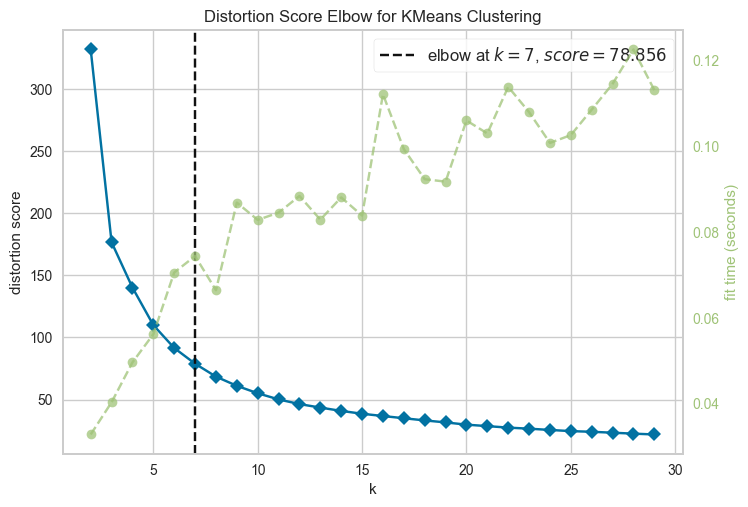

In [55]:
from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=K).fit(scaled_df)
elbow.show();

In [56]:
# Final Cluster'ların Oluşturulması
kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(scaled_df)

print(kmeans.n_clusters)
print(kmeans.cluster_centers_)
print(kmeans.labels_)

clusters_kmeans = kmeans.labels_

7
[[0.79469125 0.03548915 0.03622781]
 [0.107767   0.06023514 0.05864001]
 [0.02231984 0.81260587 0.897177  ]
 [0.07115331 0.22513656 0.21686208]
 [0.43339696 0.05388228 0.05578479]
 [0.04974385 0.59824918 0.37024582]
 [0.08882038 0.22013927 0.82485426]]
[6 3 1 ... 1 5 1]


In [58]:
rfm["clusters_kmeans"] = clusters_kmeans
rfm.clusters_kmeans = rfm.clusters_kmeans + 1
rfm.groupby("clusters_kmeans").agg({"clusters_kmeans": "count"})

,clusters_kmeans
clusters_kmeans,
1,605
2,1850
3,83
4,766
5,729
6,202
7,100


In [59]:
rfm.groupby("clusters_kmeans").agg({"RECENCY": ["mean", "median", "count"],
                                    "FREQUENCY": ["mean", "median", "count"],
                                    "MONETARY": ["mean", "median", "count"]})

RECENCY                FREQUENCY                  MONETARY                  
                       mean median count        mean median count         mean      median count
clusters_kmeans                                                                                 
1                297.419835  290.0   605   23.679339   16.0   605   402.814430    283.2800   605
2                 41.181081   37.0  1850   39.260541   33.0  1850   648.975038    537.0300  1850
3                  9.325301    5.0    83  520.295783  524.0    83  9975.647002  11118.9286    83
4                 27.703655   20.0   766  144.472585  137.5   766  2402.536867   2244.8300   766
5                162.657064  162.0   729   35.433471   24.0   729   620.267119    415.7400   729
6                 19.554455   12.0   202  383.311139  342.0   202  4116.736832   4187.7950   202
7                 34.130000   12.0   100  141.680000  128.5   100  9171.495612   9508.2150   100

In [64]:
import plotly.express as px
fig = px.scatter_3d(rfm, x=rfm["RECENCY"], y=rfm["FREQUENCY"], z=rfm["MONETARY"], 
                    color=rfm["clusters_kmeans"])
fig

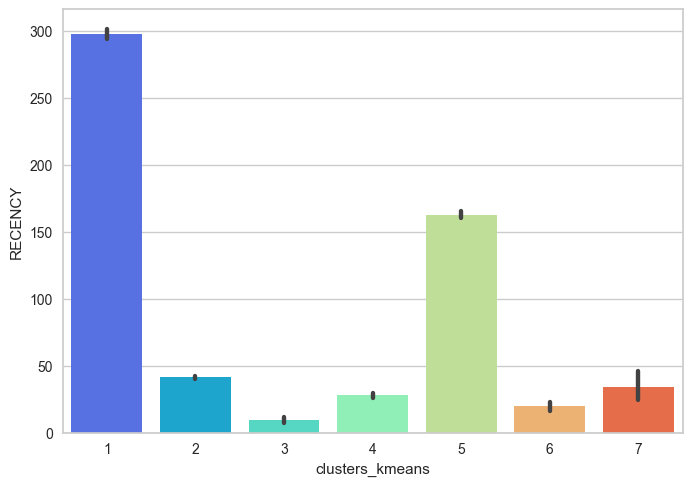

In [67]:
sns.barplot(x='clusters_kmeans', y='RECENCY', data=rfm, palette='rainbow')
plt.show()


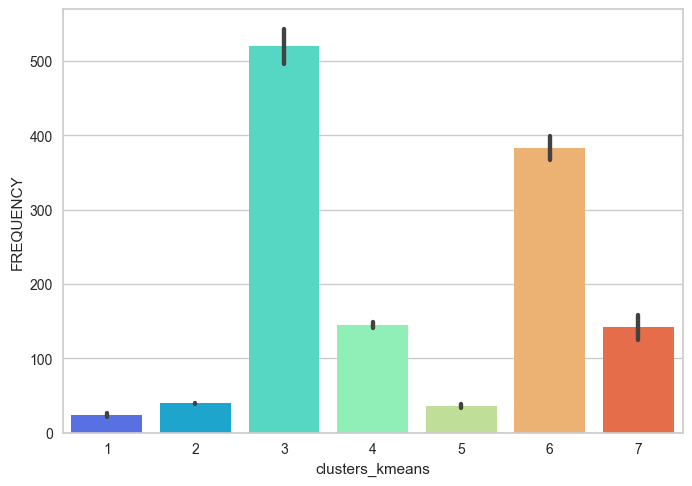

In [68]:
sns.barplot(x='clusters_kmeans', y='FREQUENCY', data=rfm, palette='rainbow')
plt.show()


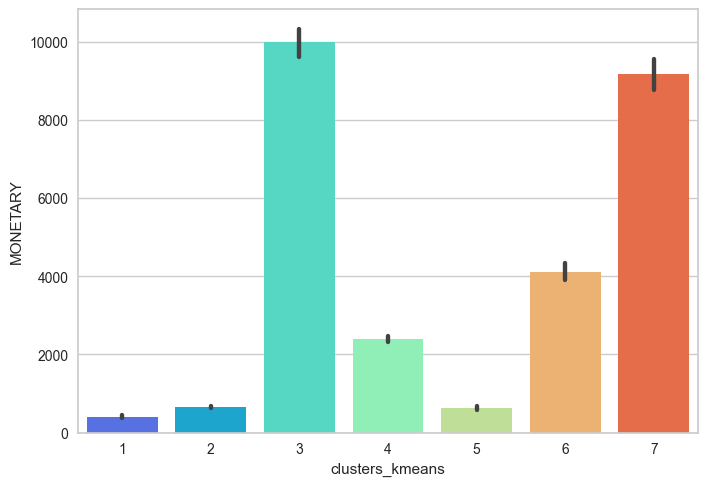

In [69]:
sns.barplot(x='clusters_kmeans', y='MONETARY', data=rfm, palette='rainbow')
plt.show()


In [70]:
dummy_df = pd.get_dummies(rfm["clusters_kmeans"], dtype=int,  prefix="KMeans_")
rfm = pd.concat([rfm, dummy_df], axis=1)
rfm

,RECENCY,FREQUENCY,MONETARY,RECENCY_SCORE,FREQUENCY_SCORE,MONETARY_SCORE,RFM_SCORE,RFM_SEGMENT,SEGMENT,LOG_RECENCY,LOG_FREQUENCY,LOG_MONETARY,clusters_kmeans,KMeans__1,KMeans__2,KMeans__3,KMeans__4,KMeans__5,KMeans__6,KMeans__7
Customer ID,,,,,,,,,,,,,,,,,,,,
12346.0,326,1.00,11118.9286,1,1,5,7,115,Hibernating,5.789960,0.693147,9.316494,7,0,0,0,0,0,0,1
12347.0,3,182.00,4310.0000,5,5,5,15,555,Champions,1.386294,5.209486,8.368925,4,0,0,0,1,0,0,0
12348.0,76,27.00,1437.2400,2,2,4,8,224,Hibernating,4.343805,3.332205,7.271175,2,0,1,0,0,0,0,0
12349.0,19,72.00,1457.5500,4,4,4,12,444,Loyal Customers,2.995732,4.290459,7.285198,2,0,1,0,0,0,0,0
12350.0,311,16.00,294.4000,1,2,2,5,122,Hibernating,5.743003,2.833213,5.688330,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,278,10.00,180.6000,1,1,1,3,111,Hibernating,5.631212,2.397895,5.201806,1,1,0,0,0,0,0,0
18281.0,181,7.00,80.8200,1,1,1,3,111,Hibernating,5.204007,2.079442,4.404522,5,0,0,0,0,1,0,0
18282.0,8,12.00,178.0500,5,1,1,7,511,New Customers,2.197225,2.564949,5.187665,2,0,1,0,0,0,0,0


In [71]:
rfm.groupby("SEGMENT").agg({"KMeans__1": "sum",
                            "KMeans__2": "sum",
                            "KMeans__3": "sum",
                            "KMeans__4": "sum",
                            "KMeans__5": "sum"})

,KMeans__1,KMeans__2,KMeans__3,KMeans__4,KMeans__5
SEGMENT,,,,,
About to Sleep,0,309,0,3,0
At Risk,133,143,0,18,283
Can't Loose,10,4,0,34,27
Champions,0,106,64,295,0
Hibernating,462,170,0,1,419
Loyal Customers,0,280,19,390,0
Need Attention,0,207,0,1,0
New Customers,0,58,0,1,0
Potential Loyalists,0,476,0,22,0


# Hierarchical Clustering

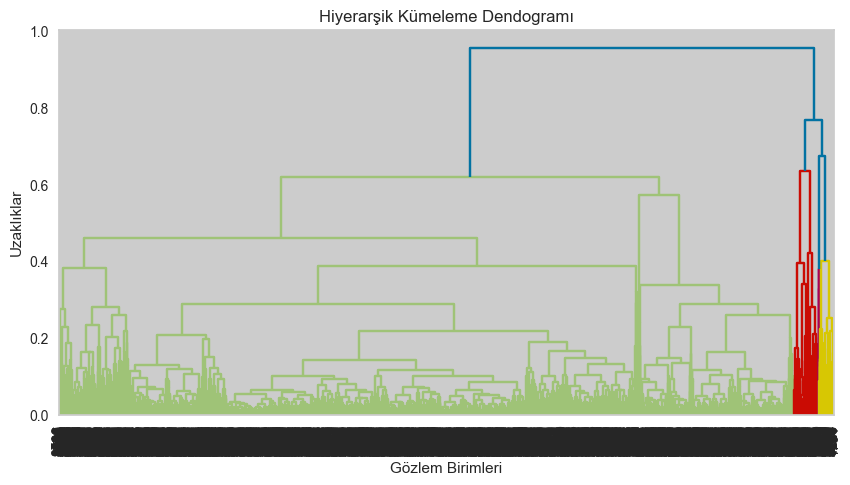

In [72]:
hc_average = linkage(scaled_df, "average")
plt.figure(figsize=(10, 5))
plt.title("Hiyerarşik Kümeleme Dendogramı")
plt.xlabel("Gözlem Birimleri")
plt.ylabel("Uzaklıklar")
dendrogram(hc_average,
           leaf_font_size=10)
plt.show()

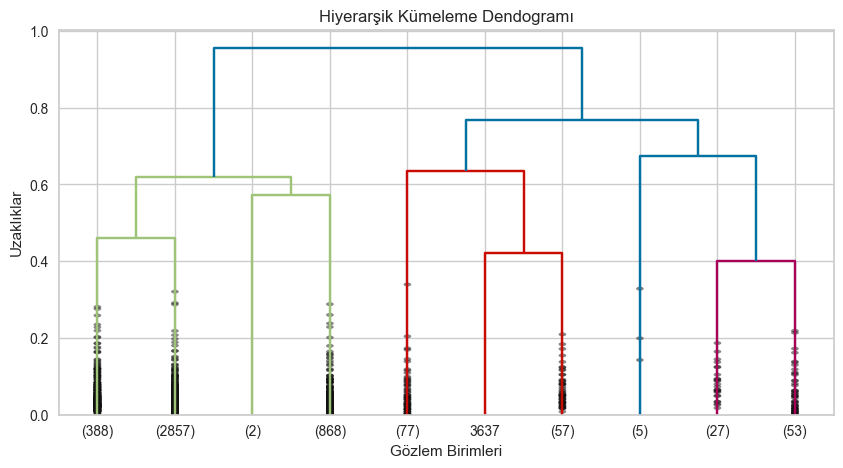

In [73]:
plt.figure(figsize=(10, 5))
plt.title("Hiyerarşik Kümeleme Dendogramı")
plt.xlabel("Gözlem Birimleri")
plt.ylabel("Uzaklıklar")
dendrogram(hc_average,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.show()


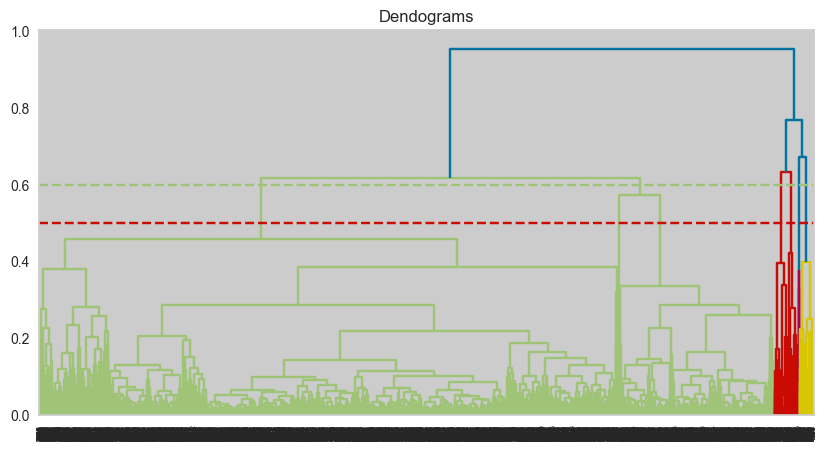

In [74]:
# Kume Sayısını Belirlemek

plt.figure(figsize=(10, 5))
plt.title("Dendograms")
dend = dendrogram(hc_average)
plt.axhline(y=0.5, color="r", linestyle="--")
plt.axhline(y=0.6, color="g", linestyle="--")
plt.show()

In [75]:
# Final Modeli Oluşturmak

from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=5, linkage="average")
hierarchical_clusters = cluster.fit_predict(scaled_df)
rfm["hierarchical_clusters"] = hierarchical_clusters
rfm.hierarchical_clusters = rfm.hierarchical_clusters + 1

In [76]:
rfm.groupby("hierarchical_clusters").agg({"RECENCY": ["mean", "median", "count"],
                                    "FREQUENCY": ["mean", "median", "count"],
                                    "MONETARY": ["mean", "median", "count"]})

RECENCY                FREQUENCY                   MONETARY                  
                             mean median count        mean median count          mean      median count
hierarchical_clusters                                                                                  
1                       97.049332   54.0  4115   66.968408   38.0  4115   1099.665903    621.7500  4115
2                       17.724138   10.0    58  524.219828  517.0    58   3494.078966   3567.6050    58
3                       22.375000   11.0    80  134.850000  117.5    80   9547.157318  11043.8150    80
4                      246.600000  236.0     5   48.000000   10.0     5  10106.103160  11118.9286     5
5                        8.441558    5.0    77  535.437013  579.0    77  10018.814951  11118.9286    77

In [77]:
dummy_df2 = pd.get_dummies(rfm["hierarchical_clusters"], dtype=int,  prefix="Hierarchical_")
rfm = pd.concat([rfm, dummy_df2], axis=1)
rfm

,RECENCY,FREQUENCY,MONETARY,RECENCY_SCORE,FREQUENCY_SCORE,MONETARY_SCORE,RFM_SCORE,RFM_SEGMENT,SEGMENT,LOG_RECENCY,...,KMeans__4,KMeans__5,KMeans__6,KMeans__7,hierarchical_clusters,Hierarchical__1,Hierarchical__2,Hierarchical__3,Hierarchical__4,Hierarchical__5
Customer ID,,,,,,,,,,,,,,,,,,,,,
12346.0,326,1.00,11118.9286,1,1,5,7,115,Hibernating,5.789960,...,0,0,0,1,4,0,0,0,1,0
12347.0,3,182.00,4310.0000,5,5,5,15,555,Champions,1.386294,...,1,0,0,0,1,1,0,0,0,0
12348.0,76,27.00,1437.2400,2,2,4,8,224,Hibernating,4.343805,...,0,0,0,0,1,1,0,0,0,0
12349.0,19,72.00,1457.5500,4,4,4,12,444,Loyal Customers,2.995732,...,0,0,0,0,1,1,0,0,0,0
12350.0,311,16.00,294.4000,1,2,2,5,122,Hibernating,5.743003,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,278,10.00,180.6000,1,1,1,3,111,Hibernating,5.631212,...,0,0,0,0,1,1,0,0,0,0
18281.0,181,7.00,80.8200,1,1,1,3,111,Hibernating,5.204007,...,0,1,0,0,1,1,0,0,0,0
18282.0,8,12.00,178.0500,5,1,1,7,511,New Customers,2.197225,...,0,0,0,0,1,1,0,0,0,0


In [78]:
rfm.groupby("SEGMENT").agg({"Hierarchical__1": "sum",
                            "Hierarchical__2": "sum",
                            "Hierarchical__3": "sum",
                            "Hierarchical__4": "sum",
                            "Hierarchical__5": "sum"})

,Hierarchical__1,Hierarchical__2,Hierarchical__3,Hierarchical__4,Hierarchical__5
SEGMENT,,,,,
About to Sleep,312,0,1,0,0
At Risk,577,0,4,1,0
Can't Loose,80,2,1,1,0
Champions,488,37,37,0,64
Hibernating,1053,0,2,3,0
Loyal Customers,742,19,25,0,13
Need Attention,208,0,2,0,0
New Customers,59,0,3,0,0
Potential Loyalists,498,0,4,0,0


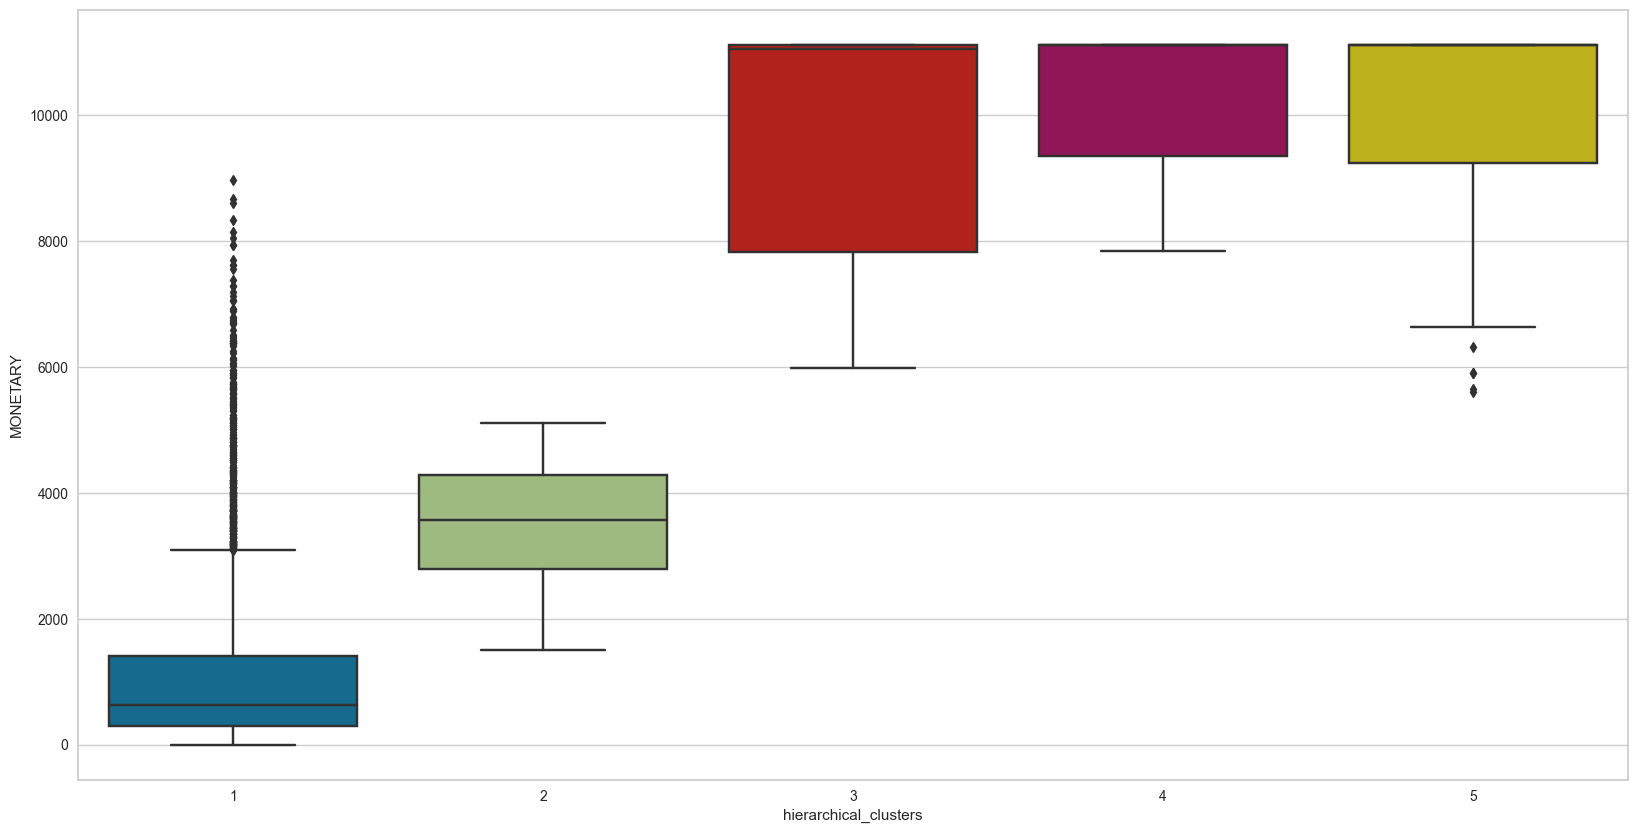

In [79]:
plt.figure(figsize=(20, 10))
sns.boxplot(x="hierarchical_clusters", y="MONETARY", data=rfm)
plt.show();